Loading dataset...
Skipping row 4872 due to incorrect pixel data length: 1993
Building and training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.2371 - loss: 1.8593 - val_accuracy: 0.2554 - val_loss: 1.7790
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.2680 - loss: 1.7740 - val_accuracy: 0.2964 - val_loss: 1.7292
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.3128 - loss: 1.7192 - val_accuracy: 0.3415 - val_loss: 1.6665
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.3538 - loss: 1.6655 - val_accuracy: 0.3774 - val_loss: 1.5910
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.3930 - loss: 1.5528 - val_accuracy: 0.4000 - val_loss: 1.5639
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.4311 - loss: 1.4966 - val_accuracy: 0.3979 - val_loss: 1.5297
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.4496 - loss: 1.4542 - val_accuracy: 0.4072 - val_loss: 1.5266
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.4613 - loss: 1.4265 - val_accu

Model saved as emotion_model.h5
Testing on sample image from validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


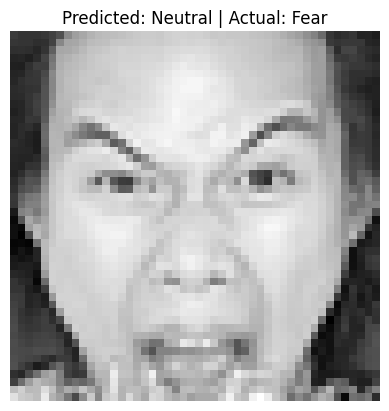

Starting real-time webcam emotion detection...


In [ ]:
#Emotion Detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Load & Preprocess Data
print("Loading dataset...")
data_path = "fer2013.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError("Dataset file 'fer2013.csv' not found. Download it from Kaggle.")

data = pd.read_csv(data_path)

valid_data = data[data['pixels'].apply(lambda x: len(x.split()) == 48 * 48)].copy()

valid_data['pixels'] = valid_data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48, 1))

X = np.array(valid_data['pixels'].tolist()) / 255.0
y = to_categorical(np.array(valid_data['emotion']), num_classes=7)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Build and Train Model
print("Building and training model...")
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

model.save("emotion_model.h5")
print("Model saved as emotion_model.h5")

#Predict & Visualize Static Image
print("Testing on sample image from validation set...")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
sample_index = 100

test_image = X_val[sample_index]
test_label = y_val[sample_index]
predicted = model.predict(test_image.reshape(1, 48, 48, 1))
predicted_class = emotion_labels[np.argmax(predicted)]

plt.imshow(test_image.reshape(48,48), cmap='gray')
plt.title(f"Predicted: {predicted_class} | Actual: {emotion_labels[np.argmax(test_label)]}")
plt.axis('off')
plt.show()

#Real-Time Emotion Detection
print("Starting real-time webcam emotion detection...")
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
model = load_model("emotion_model.h5")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(grayscale, 1.3, 5)

    for (x, y, w, h) in faces:
        roi = grayscale[y:y+h, x:x+w]
        if roi.shape[0] < 48 or roi.shape[1] < 48:
            continue  # skip tiny faces
        roi_resized = cv2.resize(roi, (48,48)).reshape(1,48,48,1) / 255.0
        prediction = model.predict(roi_resized)
        emotion = emotion_labels[np.argmax(prediction)]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    cv2.imshow("Emotion Detector - Press Q to Exit", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()